In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyspark
print(pyspark.__version__)


3.5.0


In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer

from pyspark.ml.classification import RandomForestClassifier


from pyspark.ml.evaluation import BinaryClassificationEvaluator


from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression



from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import umap
from umap import UMAP


import warnings

# Data Summary

In [4]:
file_path = 'weatherAUS.csv'  
try:
    df = pd.read_csv(file_path)
    print(f"File '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the file path and try again.")
    df = None

total_size = df.size
print("Total number of elements:", total_size)

File 'weatherAUS.csv' loaded successfully.
Total number of elements: 3345580


In [5]:
print("Preview of the Dataset (Head):")
display(df.head())

Preview of the Dataset (Head):


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
print("\nSummary Statistics for Numerical Columns:")
numerical_summary = df.describe(include=[float, int]) 
display(numerical_summary)


Summary Statistics for Numerical Columns:


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [7]:
print("\nSummary Statistics for Categorical Columns:")
categorical_summary = df.describe(include=[object]) 
display(categorical_summary)


Summary Statistics for Categorical Columns:


,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


In [8]:
print("\nNull Values in Each Column:")
null_values = df.isnull().sum()
display(null_values)


Null Values in Each Column:


Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

# Missing Values

In [9]:
binary_columns = ['RainToday', 'RainTomorrow']  # only for yes or no values
for col in binary_columns:
    if col in df.columns:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{col}' with the mode: {mode_value}")

Filled missing values in 'RainToday' with the mode: No
Filled missing values in 'RainTomorrow' with the mode: No


In [10]:
# Fill missing values in numerical columns 
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if df[col].isnull().sum() > 0:
        mean_value = df[col].mean()  #  can use median
        df[col].fillna(mean_value, inplace=True)
        print(f"Filled missing values in numerical column '{col}' with the mean: {mean_value}")


Filled missing values in numerical column 'MinTemp' with the mean: 12.19403438096892
Filled missing values in numerical column 'MaxTemp' with the mean: 23.22134827564685
Filled missing values in numerical column 'Rainfall' with the mean: 2.3609181499166656
Filled missing values in numerical column 'Evaporation' with the mean: 5.468231522922462
Filled missing values in numerical column 'Sunshine' with the mean: 7.6111775206611565
Filled missing values in numerical column 'WindGustSpeed' with the mean: 40.03523007167319
Filled missing values in numerical column 'WindSpeed9am' with the mean: 14.043425914971502
Filled missing values in numerical column 'WindSpeed3pm' with the mean: 18.662656778887342
Filled missing values in numerical column 'Humidity9am' with the mean: 68.88083133761887
Filled missing values in numerical column 'Humidity3pm' with the mean: 51.5391158755046
Filled missing values in numerical column 'Pressure9am' with the mean: 1017.6499397983052
Filled missing values in nu

In [11]:
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col not in binary_columns and df[col].isnull().sum() > 0:  # Exclude Yes/No columns already handled
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with the mode: {mode_value}")


Filled missing values in categorical column 'WindGustDir' with the mode: W
Filled missing values in categorical column 'WindDir9am' with the mode: N
Filled missing values in categorical column 'WindDir3pm' with the mode: SE


In [12]:


output_file_path = 'weatherAUS_updated.csv'

# Save the updated DF to a CSV file
df.to_csv(output_file_path, index=False)

print(f"\dataset saved successfully to '{output_file_path}'")







\dataset saved successfully to 'weatherAUS_updated.csv'


# Outliers

In [13]:
file_path = 'weatherAUS_updated.csv'  
try:
    df = pd.read_csv(file_path)
    print(f"File '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the file path and try again.")
    df = None

total_size = df.size
print("Total number of elements:", total_size)


File 'weatherAUS_updated.csv' loaded successfully.
Total number of elements: 3345580


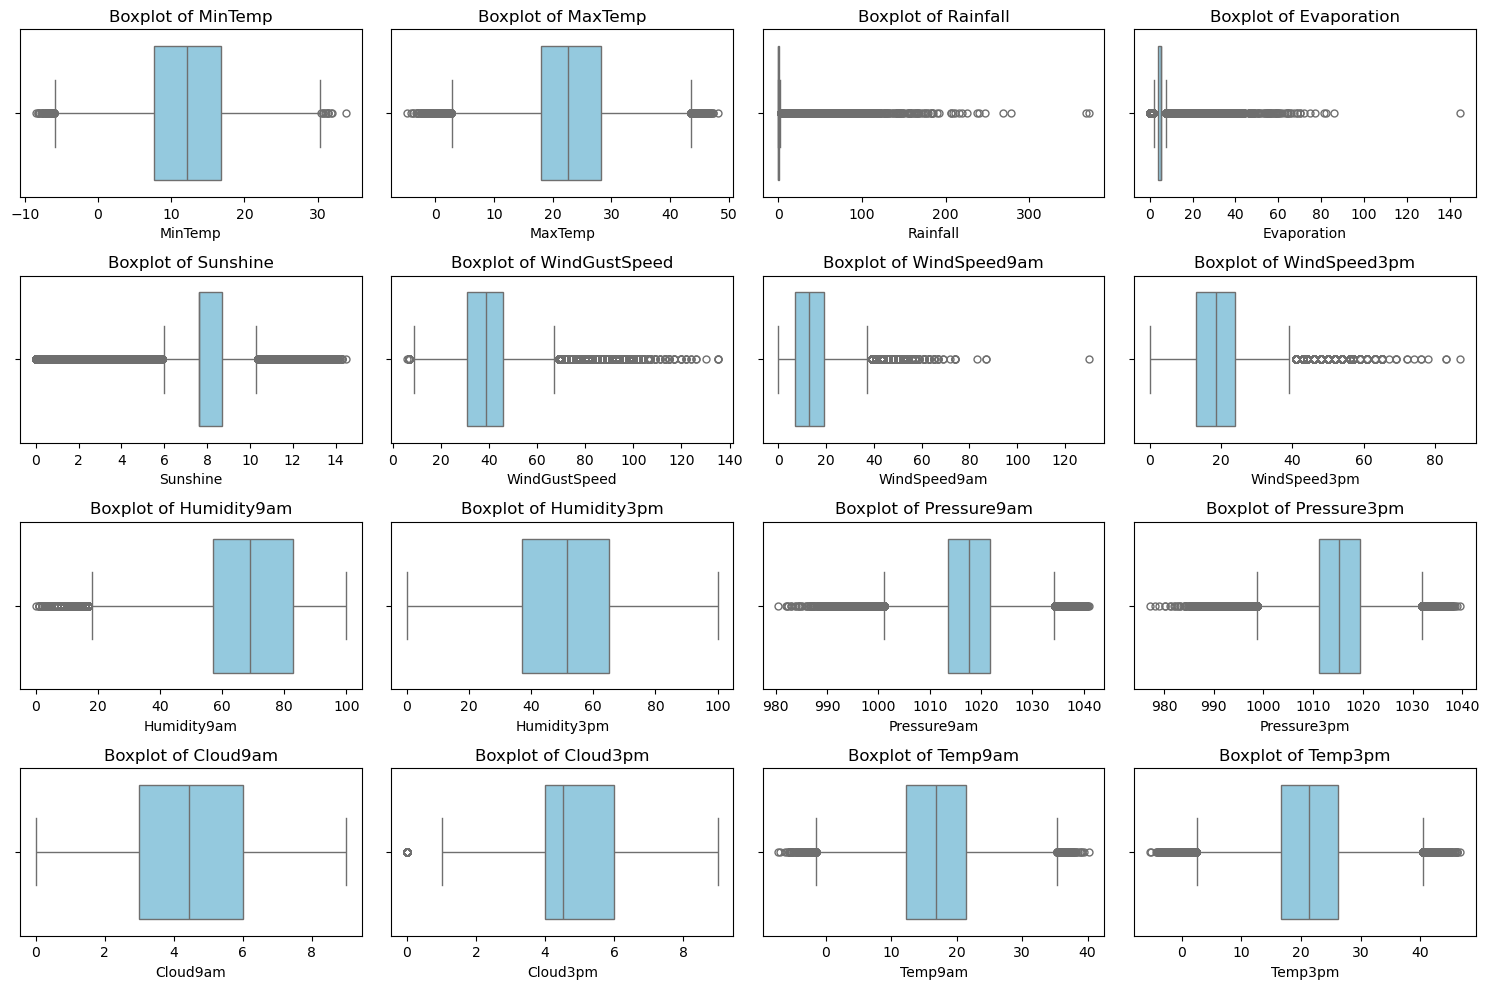

In [14]:
# Only numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))

# Create boxplots for each numerical column
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i + 1)  
    sns.boxplot(data=df, x=col, color='skyblue', fliersize=5)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

# Show the plots
plt.show()

In [15]:
from scipy.stats import zscore

# Select only numerical columns for Z-score calculation
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize a dictionary to store outlier counts
outliers_info = {}

In [16]:
for col in numerical_columns:
    # Calculate Z-scores for the column
    z_scores = zscore(df[col])
    
    # Identify outliers (where absolute Z-score > threshold)
    outliers = np.abs(z_scores) > 3
    
    # Get the count of outliers 
    outlier_count = outliers.sum()  # Sum of True values gives the number of outliers
    
    # Store the outlier count in the dictionary
    outliers_info[col] = outlier_count




In [17]:
for col, outlier_count in outliers_info.items():
    print(f"Number of outliers in '{col}': {outlier_count}")

Number of outliers in 'MinTemp': 26
Number of outliers in 'MaxTemp': 346
Number of outliers in 'Rainfall': 2482
Number of outliers in 'Evaporation': 1867
Number of outliers in 'Sunshine': 0
Number of outliers in 'WindGustSpeed': 1717
Number of outliers in 'WindSpeed9am': 1362
Number of outliers in 'WindSpeed3pm': 958
Number of outliers in 'Humidity9am': 585
Number of outliers in 'Humidity3pm': 0
Number of outliers in 'Pressure9am': 772
Number of outliers in 'Pressure3pm': 666
Number of outliers in 'Cloud9am': 0
Number of outliers in 'Cloud3pm': 0
Number of outliers in 'Temp9am': 163
Number of outliers in 'Temp3pm': 460


In [18]:
# Select only numerical columns for Z-score calculation
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Define the Z-score threshold
z_threshold = 3

# Loop through each numerical column
for col in numerical_columns:
    # Calculate Z-scores for the column
    z_scores = zscore(df[col])
    
    # Calculate the upper and lower bounds based on Z-threshold
    mean_value = df[col].mean()
    std_dev = df[col].std()
    lower_bound = mean_value - z_threshold * std_dev
    upper_bound = mean_value + z_threshold * std_dev
    
    # Identify an example outlier (if any exist)
    outlier_indices = df[(z_scores > z_threshold) | (z_scores < -z_threshold)].index
    if len(outlier_indices) > 0:
        # Take the first outlier for display purposes
        example_index = outlier_indices[0]
        before_value = df.loc[example_index, col]
        
        # Cap the outlier
        capped_value = (
            upper_bound if before_value > upper_bound else lower_bound
        )
        # Display the before and after values
        print(f"Column: '{col}'")
        print(f" - Before Capping (Row {example_index}): {before_value}")
        print(f" - After Capping: {capped_value}\n")
        
        # Apply capping to the column
        df[col] = np.where(df[col] > upper_bound, upper_bound, 
                           np.where(df[col] < lower_bound, lower_bound, df[col]))
    else:
        print(f"Column: '{col}' has no outliers.\n")

Column: 'MinTemp'
 - Before Capping (Row 46923): -8.0
 - After Capping: -6.903215228998894

Column: 'MaxTemp'
 - Before Capping (Row 68): 44.8
 - After Capping: 44.48571958519393

Column: 'Rainfall'
 - Before Capping (Row 296): 28.8
 - After Capping: 27.508380832510234

Column: 'Evaporation'
 - Before Capping (Row 6063): 16.4
 - After Capping: 14.952854712019302

Column: 'Sunshine' has no outliers.

Column: 'WindGustSpeed'
 - Before Capping (Row 8): 80.0
 - After Capping: 79.38998835820152

Column: 'WindSpeed9am'
 - Before Capping (Row 3308): 48.0
 - After Capping: 40.62660283909846

Column: 'WindSpeed3pm'
 - Before Capping (Row 52): 48.0
 - After Capping: 44.81239984264633

Column: 'Humidity9am'
 - Before Capping (Row 6322): 9.0
 - After Capping: 12.316535883650047

Column: 'Humidity3pm' has no outliers.

Column: 'Pressure9am'
 - Before Capping (Row 12): 994.3
 - After Capping: 997.4645392714654

Column: 'Pressure3pm'
 - Before Capping (Row 12): 993.0
 - After Capping: 995.26397106410

In [19]:
print("\nUpdated Summary Statistics for Numerical Columns:")
numerical_summary = df.describe(include=[float, int])
display(numerical_summary)


Updated Summary Statistics for Numerical Columns:


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.194085,23.224437,1.969541,5.387934,7.611178,39.942171,13.992645,18.624717,68.894005,51.539116,1017.663747,1015.266767,4.447461,4.509930,16.991338,21.686191
std,6.365420,7.074739,5.106232,2.594957,2.729486,12.774919,8.670736,8.577905,18.813284,20.471189,6.674746,6.619300,2.265604,2.092954,6.444951,6.833782
min,-6.903215,1.956977,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,12.316536,0.000000,997.464539,995.263971,0.000000,0.000000,-2.357031,1.133219
25%,7.700000,18.000000,0.000000,4.000000,7.611178,31.000000,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.100000,3.000000,4.000000,12.300000,16.700000
50%,12.100000,22.700000,0.000000,5.468232,7.611178,39.000000,13.000000,18.662657,69.000000,51.539116,1017.649940,1015.255889,4.447461,4.509930,16.800000,21.400000
75%,16.800000,28.200000,1.000000,5.468232,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.200000
max,31.291284,44.485720,27.508381,14.952855,14.500000,79.389988,40.626603,44.812400,100.000000,100.000000,1037.835340,1035.247807,9.000000,9.000000,36.338294,42.233561


# Visualization and EDA

Using a random sample of 20000 rows out of 145460.


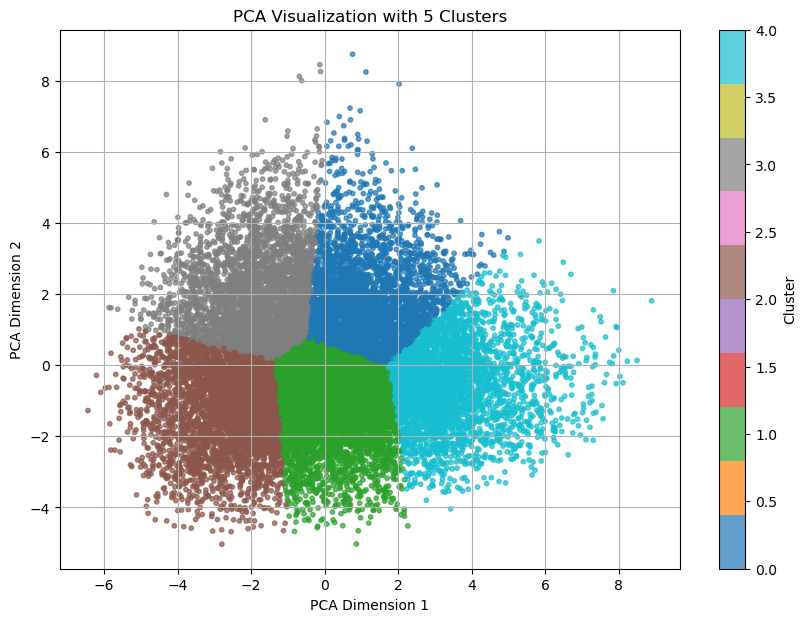

In [20]:
max_samples = 20000  # Adjust based on memory constraints (Actually so we wont take all day)
if len(df) > max_samples:
    df_sampled = df.sample(max_samples, random_state=42)
    print(f"Using a random sample of {max_samples} rows out of {len(df)}.")
else:
    df_sampled = df.copy()
    print(f"Using the full dataset of {len(df)} rows.")
    
# Separate numerical and categorical columns
numerical_columns = df_sampled.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df_sampled.select_dtypes(include=['object']).columns

# Standardize numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(df_sampled[numerical_columns])

# Encode categorical data using sparse matrices
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
categorical_data_encoded = encoder.fit_transform(df_sampled[categorical_columns])

# Combine numerical and categorical data
if len(categorical_columns) > 0:
    combined_data = hstack([numerical_data_scaled, categorical_data_encoded])
else:
    combined_data = numerical_data_scaled

# Apply PCA 
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(combined_data.toarray())  # Convert sparse matrix to dense if applicable

# K-Means clustering
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pca_embedding)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pca_embedding[:, 0], pca_embedding[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7, s=10
)
plt.title(f'PCA Visualization with {n_clusters} Clusters')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [21]:
max_samples = 20000  # Adjust based on memory constraints
if len(df) > max_samples:
    df_sampled = df.sample(max_samples, random_state=42)
    print(f"Using a random sample of {max_samples} rows out of {len(df)}.")
else:
    df_sampled = df.copy()
    print(f"Using the full dataset of {len(df)} rows.")




Using a random sample of 20000 rows out of 145460.


In [22]:
# Preprocess the data for UMAP
# Separate numerical and categorical columns
numerical_columns = df_sampled.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df_sampled.select_dtypes(include=['object']).columns

# Scale numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(df_sampled[numerical_columns])

# Encode categorical data using sparse matrices
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
categorical_data_encoded = encoder.fit_transform(df_sampled[categorical_columns])




In [23]:
# Combine numerical and encoded categorical data 
if categorical_columns.any():
    combined_data = hstack([numerical_data_scaled, categorical_data_encoded])
else:
    combined_data = numerical_data_scaled 

# Suppress the UMAP warning for n_jobs and use random_state for reproducibility
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="umap")

    # Apply UMAP
    umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, low_memory=True)
    embedding = umap_reducer.fit_transform(combined_data)

n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  
cluster_labels = kmeans.fit_predict(embedding)



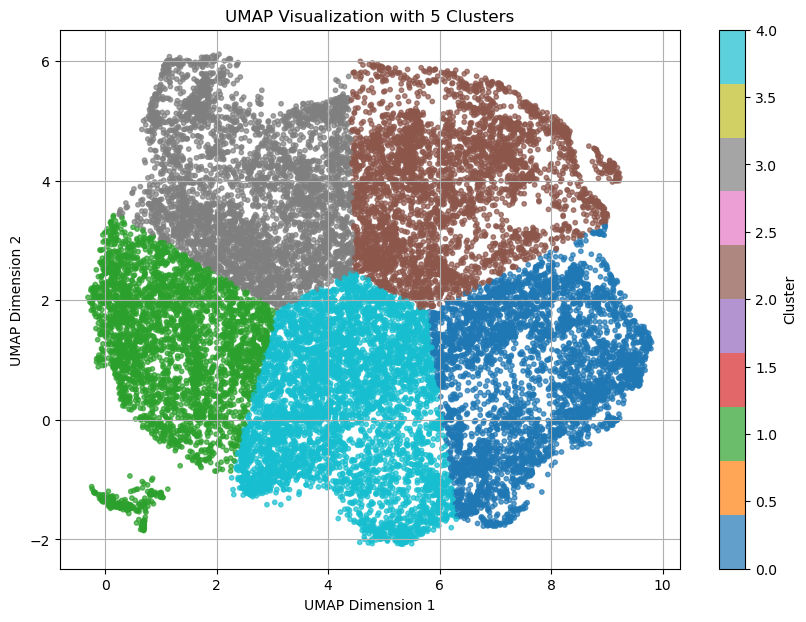

In [24]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7, s=10)
plt.title(f'UMAP Visualization with {n_clusters} Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

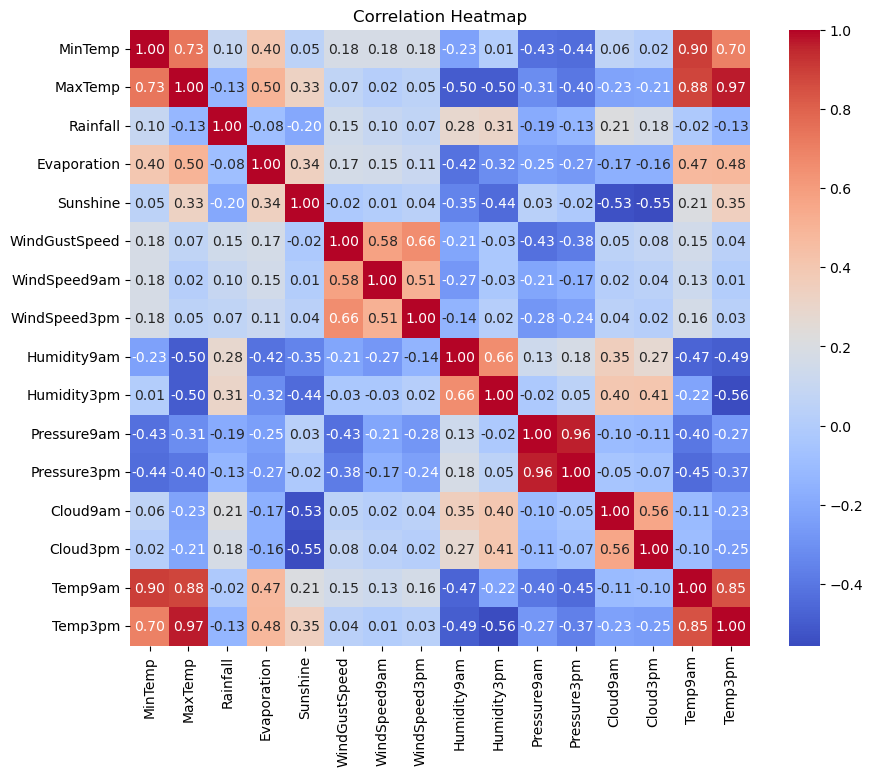

In [25]:
# Correlation heatmap
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

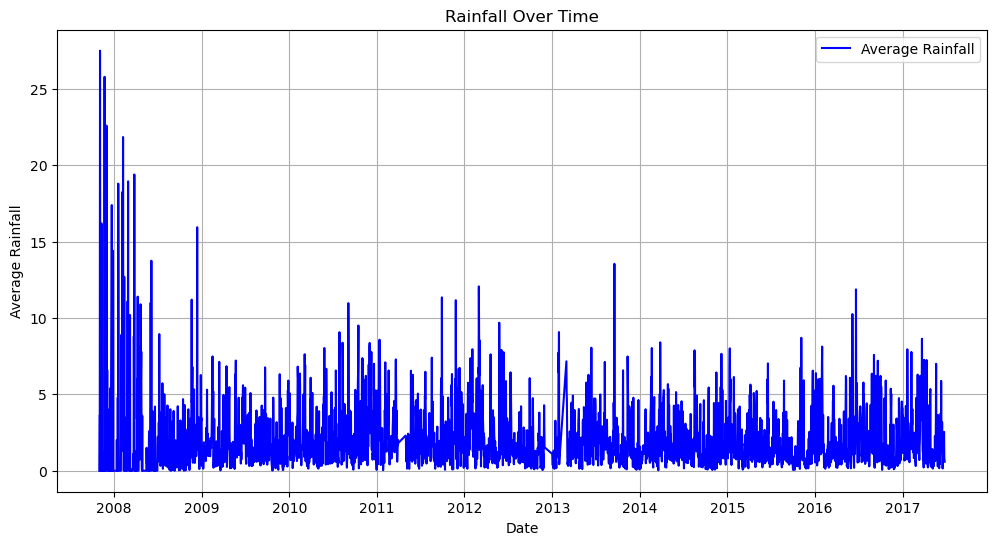

In [26]:
# Plot average Rainfall over time
df['Date'] = pd.to_datetime(df['Date'])


rainfall_over_time = df.groupby('Date')['Rainfall'].mean()

plt.figure(figsize=(12, 6))
plt.plot(rainfall_over_time, label='Average Rainfall', color='blue')
plt.title('Rainfall Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rainfall')
plt.legend()
plt.grid(True)
plt.show()

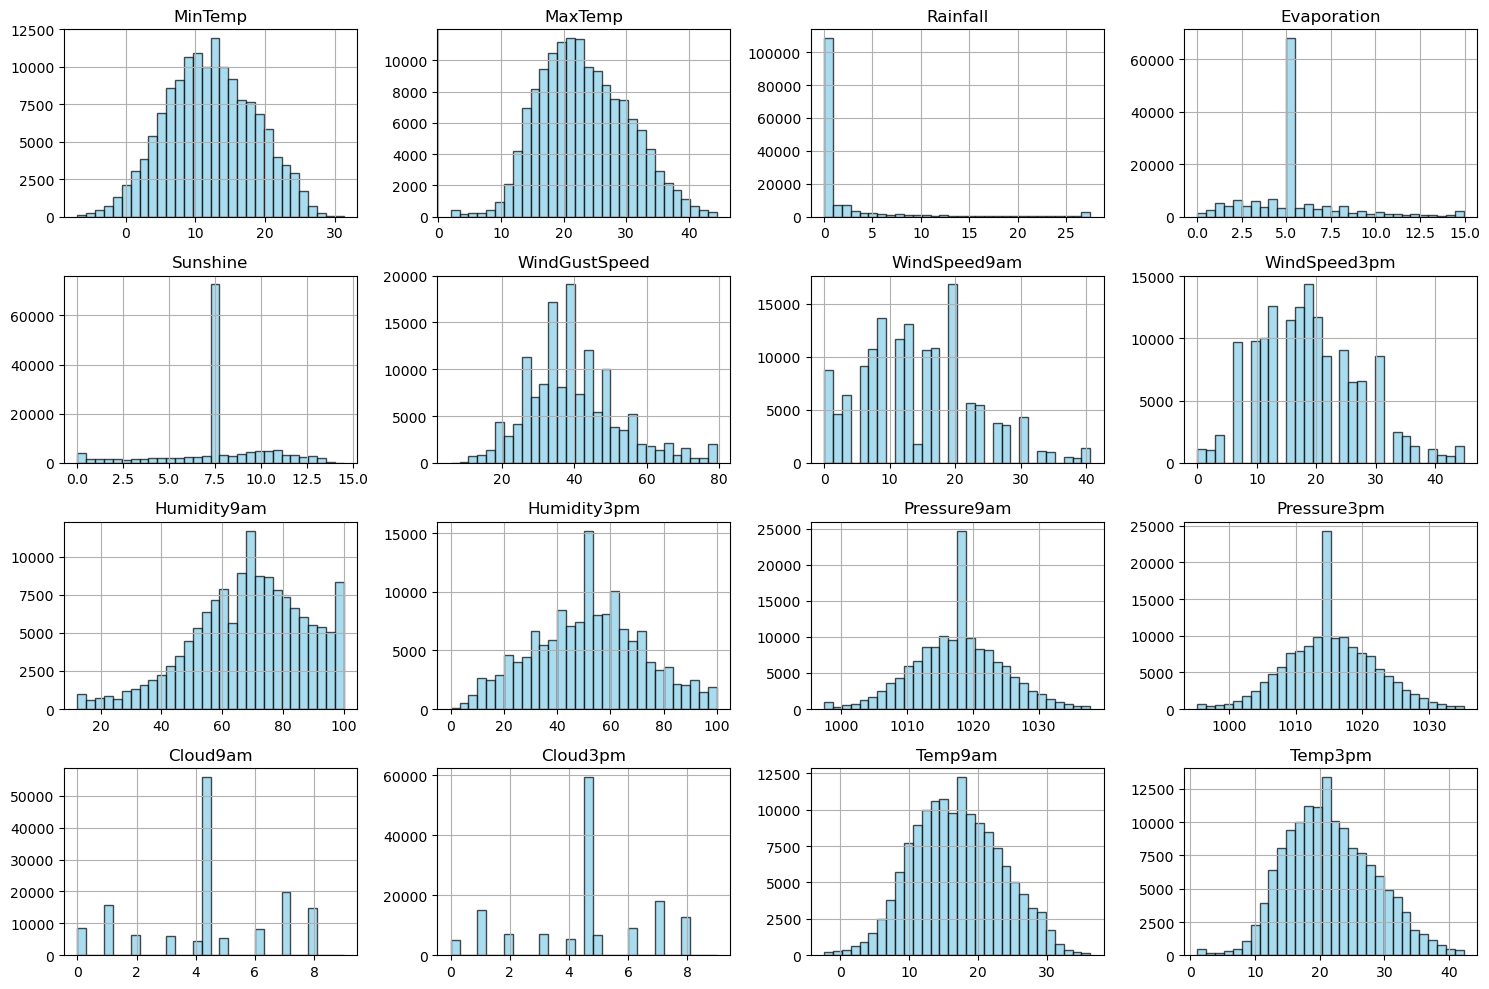

In [28]:
# Plot histograms for numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1)
    df[col].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.tight_layout()
plt.show()

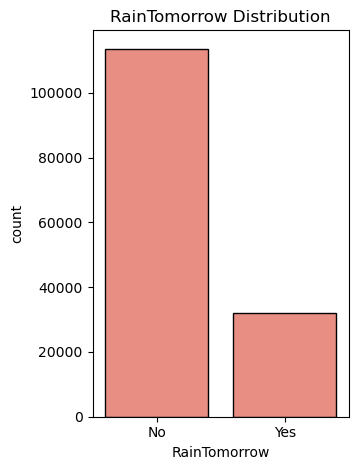

In [29]:
# RainTomorrow Distribution
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='RainTomorrow', color='salmon', edgecolor='black')  # Simplified palette
plt.title('RainTomorrow Distribution')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'RainToday Distribution')

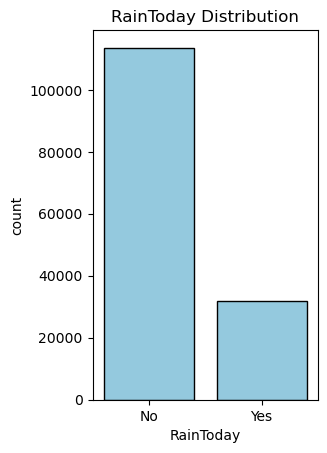

In [30]:
# RainToday RainTomorrow                                                                    Distributionplt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='RainToday', color='skyblue', edgecolor='black')  # Simplified palette
plt.title('RainToday Distribution')

# Machine Learning

In [31]:
from pyspark.sql.functions import col, when

# Initialize Spark session
spark = SparkSession.builder.appName("Random Forest WeatherPrediction").getOrCreate()

# Convert df to spark df
spark_df = spark.createDataFrame(df)

# Encode categorical variables into numeric 
indexer = StringIndexer(inputCol="Location", outputCol="LocationIndex")
spark_df = indexer.fit(spark_df).transform(spark_df)

indexer_wind_dir = StringIndexer(inputCol="WindGustDir", outputCol="WindGustDirIndex")
spark_df = indexer_wind_dir.fit(spark_df).transform(spark_df)

indexer_rain_today = StringIndexer(inputCol="RainToday", outputCol="RainTodayIndex")
spark_df = indexer_rain_today.fit(spark_df).transform(spark_df)

# Assemble feature columns into a single vector
assembler = VectorAssembler(
    inputCols=[
        'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
        'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 
        'LocationIndex', 'WindGustDirIndex', 'RainTodayIndex'
    ], 
    outputCol="features"
)
spark_df = assembler.transform(spark_df)

# Encode target variable as a numeric label
indexer_target = StringIndexer(inputCol="RainTomorrow", outputCol="label")
spark_df = indexer_target.fit(spark_df).transform(spark_df)

# Split data into training and testing sets
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=1234)

# Train Random Forest 
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, maxDepth=5, maxBins=100)
model = rf.fit(train_df)

# Generate predictions on test data
predictions = model.transform(test_df)

# Map numeric predictions back to 'Yes' or 'No'
predictions = predictions.withColumn(
    "predicted_outcome",
    when(col("prediction") == 0, "No").otherwise("Yes")
)

# Display a random sample of predictions
predictions.sample(withReplacement=False, fraction=0.1, seed=1234).select("Date", "Location", "predicted_outcome").show(20)

# Evaluate the model using AUC 
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC (AUC): {auc}")

# Stop Spark session
spark.stop()


+-------------------+-------------+-----------------+
|               Date|     Location|predicted_outcome|
+-------------------+-------------+-----------------+
|2009-01-21 00:00:00|        Cobar|               No|
|2009-01-25 00:00:00|        Cobar|               No|
|2009-01-31 00:00:00|BadgerysCreek|               No|
|2009-02-07 00:00:00|       Albury|               No|
|2009-02-11 00:00:00|BadgerysCreek|               No|
|2009-02-13 00:00:00| CoffsHarbour|              Yes|
|2009-02-23 00:00:00|       Albury|               No|
|2009-02-26 00:00:00| CoffsHarbour|               No|
|2009-04-03 00:00:00|        Cobar|               No|
|2009-04-03 00:00:00| CoffsHarbour|              Yes|
|2009-04-07 00:00:00| CoffsHarbour|              Yes|
|2009-04-10 00:00:00|       Albury|               No|
|2009-05-17 00:00:00|BadgerysCreek|               No|
|2009-05-30 00:00:00|        Cobar|               No|
|2009-06-02 00:00:00| CoffsHarbour|               No|
|2009-06-10 00:00:00| CoffsH

In [32]:
from pyspark.sql.functions import col, when

# Init Spark session
spark = SparkSession.builder.appName(" GBT WeatherPrediction").getOrCreate()

# Convert Pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(df)

# SHandle categorical variables 
indexer = StringIndexer(inputCol="Location", outputCol="LocationIndex")
spark_df = indexer.fit(spark_df).transform(spark_df)

indexer_wind_dir = StringIndexer(inputCol="WindGustDir", outputCol="WindGustDirIndex")
spark_df = indexer_wind_dir.fit(spark_df).transform(spark_df)

indexer_rain_today = StringIndexer(inputCol="RainToday", outputCol="RainTodayIndex")
spark_df = indexer_rain_today.fit(spark_df).transform(spark_df)

# feature vector
assembler = VectorAssembler(
    inputCols=[
        'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
        'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 
        'LocationIndex', 'WindGustDirIndex', 'RainTodayIndex'
    ], 
    outputCol="features"
)
spark_df = assembler.transform(spark_df)

# Encode the target variable 'RainTomorrow'
indexer_target = StringIndexer(inputCol="RainTomorrow", outputCol="label")
spark_df = indexer_target.fit(spark_df).transform(spark_df)

# Split the data into training and testing sets
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=1234)

# GBT
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, maxBins=100)

# Fit the model
model = gbt.fit(train_df)

#  Make predictions 
predictions = model.transform(test_df)

# Map the numeric predictions back to string labels ('Yes' or 'No')
predictions = predictions.withColumn(
    "predicted_outcome",
    when(col("prediction") == 0, "No").otherwise("Yes")
)

# Show predictions
predictions.select("Date", "Location", "predicted_outcome").show()

# Evaluate the model using AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
auc = evaluator.evaluate(predictions)
print(f"Area under ROC (AUC): {auc}")

# Stop session
spark.stop()

+-------------------+-------------+-----------------+
|               Date|     Location|predicted_outcome|
+-------------------+-------------+-----------------+
|2008-12-02 00:00:00|       Albury|               No|
|2008-12-05 00:00:00|       Albury|               No|
|2008-12-22 00:00:00|       Albury|               No|
|2008-12-25 00:00:00|       Albury|               No|
|2008-12-26 00:00:00|       Albury|               No|
|2008-12-27 00:00:00|       Albury|               No|
|2008-12-28 00:00:00|       Albury|               No|
|2009-01-02 00:00:00|BadgerysCreek|               No|
|2009-01-04 00:00:00|        Cobar|               No|
|2009-01-05 00:00:00|       Albury|               No|
|2009-01-06 00:00:00|BadgerysCreek|               No|
|2009-01-07 00:00:00|BadgerysCreek|               No|
|2009-01-07 00:00:00|        Cobar|               No|
|2009-01-07 00:00:00| CoffsHarbour|               No|
|2009-01-09 00:00:00|       Albury|               No|
|2009-01-09 00:00:00| CoffsH

In [33]:

from pyspark.sql.functions import col, when



# Initialize Spark session
spark = SparkSession.builder.appName("Logistic Regression WeatherPrediction").getOrCreate()

# Convert Pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(df)

#  Handle categorical variables by encoding them into numeric indices
indexer_location = StringIndexer(inputCol="Location", outputCol="LocationIndex")
spark_df = indexer_location.fit(spark_df).transform(spark_df)

indexer_wind_dir = StringIndexer(inputCol="WindGustDir", outputCol="WindGustDirIndex")
spark_df = indexer_wind_dir.fit(spark_df).transform(spark_df)

indexer_rain_today = StringIndexer(inputCol="RainToday", outputCol="RainTodayIndex")
spark_df = indexer_rain_today.fit(spark_df).transform(spark_df)

#  Assemble feature columns into a single vector
assembler = VectorAssembler(
    inputCols=[
        'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
        'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 
        'LocationIndex', 'WindGustDirIndex', 'RainTodayIndex'
    ], 
    outputCol="features"
)
spark_df = assembler.transform(spark_df)

# Encode the target variable 'RainTomorrow' as a numeric label
indexer_target = StringIndexer(inputCol="RainTomorrow", outputCol="label")
spark_df = indexer_target.fit(spark_df).transform(spark_df)

# Split the data into training and testing sets
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=1234)

# Train the Logistic Regression model
logistic_reg = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.01, elasticNetParam=0.0)
logistic_model = logistic_reg.fit(train_df)

# Make predictions on the test data
predictions = logistic_model.transform(test_df)

#  Map the numeric predictions back to string labels ('Yes' or 'No')
predictions = predictions.withColumn(
    "predicted_outcome",
    when(col("prediction") == 0, "No").otherwise("Yes")
)

# Display predictions
predictions.select("Date", "Location", "predicted_outcome").show(20)

#  Evaluate the model using AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC (AUC) for Logistic Regression: {auc}")

# Stop Spark session
spark.stop()

+-------------------+-------------+-----------------+
|               Date|     Location|predicted_outcome|
+-------------------+-------------+-----------------+
|2008-12-02 00:00:00|       Albury|               No|
|2008-12-05 00:00:00|       Albury|               No|
|2008-12-22 00:00:00|       Albury|               No|
|2008-12-25 00:00:00|       Albury|               No|
|2008-12-26 00:00:00|       Albury|               No|
|2008-12-27 00:00:00|       Albury|               No|
|2008-12-28 00:00:00|       Albury|               No|
|2009-01-02 00:00:00|BadgerysCreek|               No|
|2009-01-04 00:00:00|        Cobar|               No|
|2009-01-05 00:00:00|       Albury|               No|
|2009-01-06 00:00:00|BadgerysCreek|               No|
|2009-01-07 00:00:00|BadgerysCreek|               No|
|2009-01-07 00:00:00|        Cobar|               No|
|2009-01-07 00:00:00| CoffsHarbour|               No|
|2009-01-09 00:00:00|       Albury|               No|
|2009-01-09 00:00:00| CoffsH